# Autoencoder for the Kolmogorov Flow

In this session, you will need to use what you learned in the previous notebooks to develop a particular neural network called an autoencoder.
The Kolmogorov flow is governed by the following equation:
\begin{align}
    \nabla \cdot \mathbf{u} &= 0\\
   \partial_t \mathbf{u} + \mathbf{u} \cdot \nabla \mathbf{u} &= -\nabla p + \frac{1}{Re} \Delta \mathbf{u} + \mathbf{f}
\end{align}
where $\mathbf{u} = (u,v)$ is the flow velocity over the domain $(x,y)\in \Omega = [0,2\pi]\times[0,2\pi]$ with periodic boundary conditions and $p$ is the pressure field.
In the Kolmogorov flow, the forcing term, $\mathbf{f}$ is $\mathbf{f} = (sin(k_fy),0)$.

The Kolmogorov flow admits a laminar solution $u= \frac{Re}{k_f^2} \sin(k_fy)$, $v=0$ which is unstable for large enough $Re$ and $k_f$.

## 1. Import librairies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [7]:
import numpy as np
import tensorflow as tf
# from datetime import datetime
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, AveragePooling2D, UpSampling2D, concatenate, BatchNormalization, Conv2DTranspose, Flatten, Reshape, AveragePooling2D
from tensorflow.keras.optimizers import Adam 



# 2. Read dataset

In [12]:
hf = h5py.File('ML_WORKSHOP_Kolmogorov_Re20_T1000_DT01.h5','r')
Nx = 24
Nu = 1
t = np.array(hf.get('t'))
u_all = np.zeros((Nx,Nx,len(t),Nu))
u_all[:,:,:,0] = np.array(hf.get('u_refined'))
# u_all[:,:,:,1] = np.array(hf.get('v_refined'))
u_all = np.transpose(u_all,[2,0,1,3])
hf.close()
print(u_all.shape)

# normalize data
u_min = np.amin(u_all[:,:,:,0])
u_max = np.amax(u_all[:,:,:,0])
u_all[:,:,:,0] = (u_all[:,:,:,0] - u_min) / (u_max - u_min)
if Nu==2:
    v_min = np.amin(u_all[:,:,:,1])
    v_max = np.amax(u_all[:,:,:,1])
    u_all[:,:,:,1] = (u_all[:,:,:,1] - v_min) / (v_max - v_min)


(1000, 24, 24, 1)


NameError: ignored

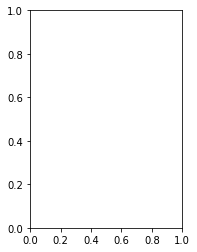

In [9]:
# visualization of the dataset
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(u_all[1,:,:,0])
# ax2 = fig.add_subplot(122)
# ax2.contourf(u_all[0,:,:,1])

# 3. Prepare dataset

In [14]:
val_ratio = int(np.round(0.75*len(u_all)))
test_ratio = int(np.round(0.95*len(u_all)))

u_train = u_all[:val_ratio,:,:,:].astype('float32')
u_val = u_all[val_ratio:test_ratio,:,:,:].astype('float32')
u_test = u_all[test_ratio:,:,:,:].astype('float32')
#del u_all


# 4. Define the network

In [33]:
input_img = Input(shape=(Nx,Nx,Nu))

nb_layer = 0

act = 'tanh'

x = Conv2D(64,(3,3), padding='same', activation=act)(input_img)
x = MaxPool2D((2,2), padding='same')(x)
x = Conv2D(32,(3,3), padding='same', activation=act)(x)
x = MaxPool2D((2,2), padding='same')(x)
x = Conv2D(16,(3,3), padding='same', activation=act)(x)
x = MaxPool2D((2,2), padding='same')(x)
x = Conv2D(8,(3,3), padding='same', activation=act)(x)
encoded = MaxPool2D((3,3), padding='same')(x)

x = Conv2DTranspose(8,(3,3), padding='same', activation=act)(encoded)
x = UpSampling2D((3,3))(x)
x = Conv2DTranspose(16,(3,3), padding='same', activation=act)(x)
x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(32,(3,3), padding='same', activation=act)(x)
x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(64,(3,3), padding='same', activation=act)(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2DTranspose(Nu,(3,3), activation='linear', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img,decoded)
encoder = tf.keras.models.Model(input_img,encoded)

# definition of the decoder
encoded_input = Input(shape=(1,1,encoded.shape[3]))
print(encoded_input.shape)
deco = autoencoder.layers[-7](encoded_input) # we re-use the same layers as the ones of the autoencoder
for i in range(6):
    deco = autoencoder.layers[-6+i](deco)

decoder = tf.keras.models.Model(encoded_input, deco)
#encoder.summary()
decoder.summary()
#autoencoder.summary()

(None, 1, 1, 8)
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1, 1, 8)]         0         
                                                                 
 conv2d_transpose_31 (Conv2D  multiple                 1168      
 Transpose)                                                      
                                                                 
 up_sampling2d_25 (UpSamplin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_transpose_32 (Conv2D  multiple                 4640      
 Transpose)                                                      
                                                                 
 up_sampling2d_26 (UpSamplin  multiple                 0         
 g2D)                                     

# 5. Training the Network
We use the difference between the network output and the real image to calculate or cost/loss function. As an optimizier we choose the AdamOptimizer and tell it which function value to minimize

In [16]:
autoencoder.compile(optimizer=Adam(learning_rate=0.001),loss='mse')

In [17]:
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [19]:
nb_epochs = 1000
batch_size = 20
hist = autoencoder.fit(u_train, u_train, epochs=nb_epochs, batch_size=batch_size,
                shuffle=True,validation_data=(u_test, u_test),
                       verbose=1,
                       callbacks=[model_checkpoint_callback,early_stop_callback])

Epoch 1/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0132 - val_loss: 0.0165
Epoch 2/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0127 - val_loss: 0.0159
Epoch 3/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0118 - val_loss: 0.0151
Epoch 4/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0102 - val_loss: 0.0126
Epoch 5/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0079 - val_loss: 0.0096
Epoch 6/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 7/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0053 - val_loss: 0.0058
Epoch 8/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0047 - val_loss: 0.0051
Epoch 9/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 10/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0042 - val_loss: 0.0045

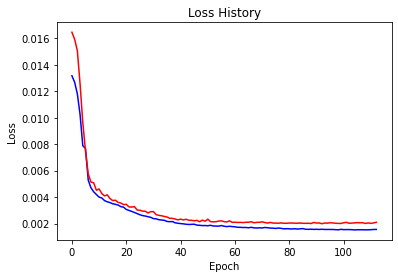

In [20]:
loss_history = hist.history['loss']
val_history = hist.history['val_loss']
%matplotlib inline
plt.plot(loss_history,'b')
plt.plot(val_history,'r')
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# 6. Visualization of some prediction cases

(6, 24, 24, 1)


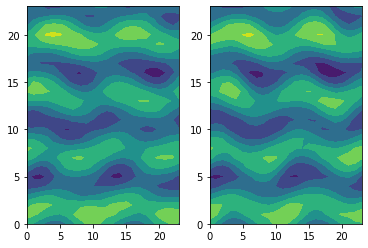

In [21]:
y_nn = autoencoder.predict(u_val[0:6,:,:,:])
print(y_nn.shape)
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(y_nn[1,:,:,0])
ax = fig.add_subplot(122)
ax.contourf(u_val[1,:,:,0])


In [22]:
print(f'AE error: {val_history[-1]}')

AE error: 0.0020930797327309847


In [41]:
n = 10  # figure with 15x15 digits
digit_size = 24
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
print(grid_x)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

[-15.         -11.66666667  -8.33333333  -5.          -1.66666667
   1.66666667   5.           8.33333333  11.66666667  15.        ]


ValueError: ignored